In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ezgatr.interfaces import point
from ezgatr.nets.mv_only_gatr import MVOnlyGATrModel, MVOnlyGATrConfig
from ezgatr.nn.functional import equi_linear, geometric_product
from tqdm import tqdm
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance
from pytorch3d.transforms import random_rotation

In [2]:
def plot_pointcloud(points, title=""):
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [3]:
# Load the dolphin mesh.
device = "cuda:0"
trg_obj = "dolphin.obj"

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

/home/catcat/projects/img2pc/.venv/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [5]:
net = MVOnlyGATrModel(
    MVOnlyGATrConfig(
        num_layers=1,
        attn_is_causal=False,
        attn_num_heads=4,
        size_channels_hidden=4,
        size_channels_intermediate=4,
        size_context=512,
    )
).to(device)
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=3e-4,
    weight_decay=1e-2,
)

In [6]:
rot = random_rotation(dtype=torch.float, device=device)

total_loss = 7.309798:   0%|          | 0/30000 [00:00<?, ?it/s]

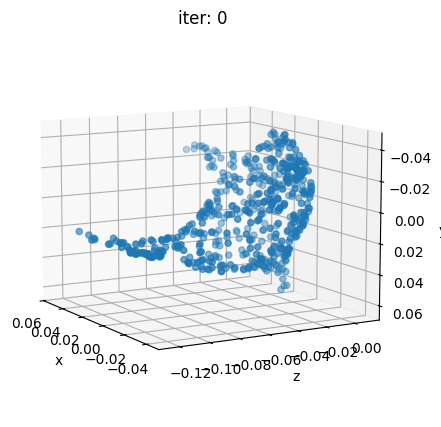

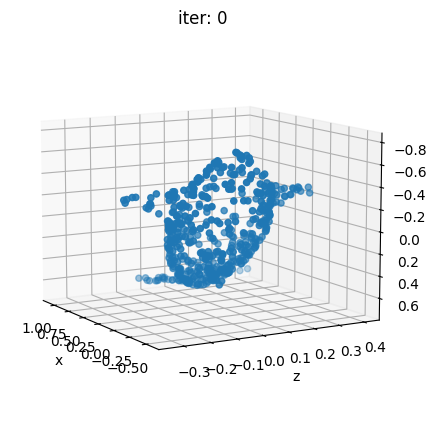

total_loss = 7.016946:   1%|          | 322/30000 [00:08<13:55, 35.51it/s]

In [ ]:
# Number of optimization steps
Niter = 30000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 5000
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    x = sample_points_from_meshes(trg_mesh, 512)
    # y = sample_points_from_meshes(trg_mesh, 1024)
    y = x.detach() @ rot.T

    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    # mask = torch.tensor(
    #     [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    #     dtype=torch.float,
    #     device=device,
    # )
    # p = point.decode_pga(geometric_product(gp, point.encode_pga(x).unsqueeze(-2))).squeeze(-2)
    p = point.decode_pga(net(point.encode_pga(x).unsqueeze(-2))).squeeze(-2)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    # loss, _ = chamfer_distance(p, y)
    loss = torch.sqrt(torch.sum((p - y)**2, dim=1)).mean()

    # # and (b) the edge length of the predicted mesh
    # loss_edge = mesh_edge_loss(p)

    # # mesh normal consistency
    # loss_normal = mesh_normal_consistency(p)
    
    # # mesh laplacian smoothing
    # loss_laplacian = mesh_laplacian_smoothing(p, method="uniform")
    
    # Weighted sum of the losses
    # loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss.detach().cpu()))
    # edge_losses.append(float(loss_edge.detach().cpu()))
    # normal_losses.append(float(loss_normal.detach().cpu()))
    # laplacian_losses.append(float(loss_laplacian.detach().cpu()))

    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(p, title="iter: %d" % i)
        plot_pointcloud(y, title="iter: %d" % i)

    # Optimization step
    loss.backward()
    optimizer.step()